In [1]:
from datagenerator import DataGen
import numpy as np
import tensorflow as tf
import scipy as sc
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
%matplotlib inline

from IPython import display

tf.enable_eager_execution()

In [2]:
def chi_sq_dist(X):
    X_1 = tf.expand_dims(X, 1)
    X_2 = tf.expand_dims(X, 0)

    epsilon = tf.constant(0.000001)
    
    return 0.5 * tf.reduce_sum(tf.squared_difference(X_1, X_2) / (X_1+X_2 + epsilon), 2)

def chi_sq_nn(X):
    dist = chi_sq_dist(X)
    return np.argsort(np.abs(dist),axis=1)

def euclidean_nn(X):
    dist = distance_matrix(X,X)
    return np.argsort(dist,axis=1)

In [3]:
#X, y = DataGen.gauss(100, 3)
#X, y = DataGen.moons(100,10)
X, y = DataGen.circle(100,0.1)
print(X.shape)
N = X.shape[0]
dims = X.shape[1]
K = 10

(100, 2)


In [4]:

#nearest_points = chi_sq_nn(X.astype('float32'))
nearest_points = euclidean_nn(X.astype('float32'))


In [5]:
## Same Class Neighbors - Automatic v2.0
nn = np.zeros((N*K,2), dtype=np.int)
for i in range(N):
    tmp = nearest_points[i]
    idx = [elem for elem in tmp if elem in np.where(y==y[i])[0]]
    nn[i::N,1] = idx[1:K+1]
    nn[i::N,0] = np.repeat(idx[0], K)

In [6]:
## Opposite Class Neighbors - Automatic v2.0
im = np.zeros((N*K,2), dtype=np.int)
for i in range(N):
    tmp = nearest_points[i]
    idx = [elem for elem in tmp if elem in np.where(y!=y[i])[0]]
    im[i::N,1] = idx[1:K+1]
    im[i::N,0] = np.repeat(idx[0], K)

1


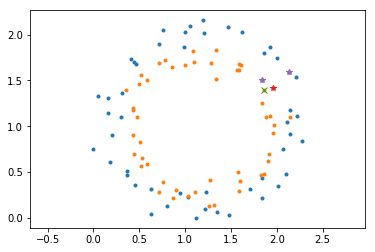

In [7]:
def plot_func(X,y):
    classes = np.unique(y)
    plt.axis('equal')
    for i in classes:
        plt.plot(X[y==i,0],X[y==i,1],'.')
    #plt.show()

t = 2
print(y[t])
plot_func(X,y)
plt.plot(X[int(nn[t,0]),0],X[int(nn[t,0]),1],'x')
plt.plot(X[nn[t,1:].astype(np.int),0],X[nn[t,1:].astype(np.int),1],'*')
plt.plot(X[im[t,:].astype(np.int),0],X[im[t,:].astype(np.int),1],'*')
plt.show()


In [8]:
def loss(X, A):
    L = tf.nn.softmax(A,axis=0)
    X_bar = tf.cast(L @ X, tf.float32)
    D = chi_sq_dist(X_bar)
    pull_term = tf.gather_nd(D, nn) # (N*K, 1) where each element 
    #D_tn = tf.gather_nd(D, im[:,:2]) # FIXME see https://github.com/SkafteNicki/Deep_LMNN/blob/master/dlmnn/helper/tf_funcs.py#L137
    D_tn = pull_term
    D_im = tf.gather_nd(D, im) # FIXME
    pull_loss = tf.reduce_sum(pull_term)
    push_loss = tf.reduce_sum(tf.nn.relu(margin + D_tn - D_im))

    loss = pull_loss + mu * push_loss
    return loss

def grad(X, A):
    with tf.GradientTape() as tape:
        loss_value = loss(X, A)
    return tape.gradient(loss_value, A)

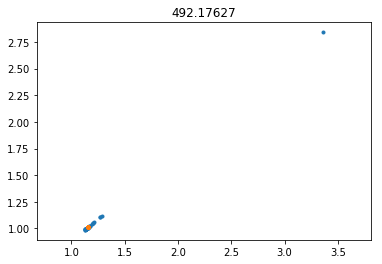

In [ ]:
A = tf.Variable(np.eye(N) + 0.01* np.ones((N,N)))

margin = 1
mu = 0.5

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
plot_func(np.array(tf.nn.softmax(A,axis=0) @ X),y)
for i in range(20000):
    grads = grad(X, A)
    optimizer.apply_gradients(zip([grads], [A]))
    
    if i % 100 == 0:
        #print(loss(X, A))
        plt.figure()
        plot_func(np.array(tf.nn.softmax(A,axis=0) @ X),y)
        plt.title(loss(X, A).numpy())
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        

#optimizer.minimize(loss)

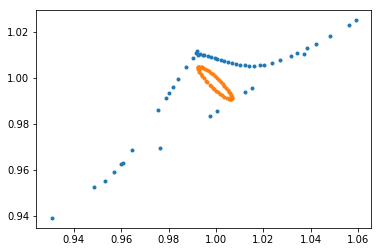

In [47]:
plot_func(np.array(tf.nn.softmax(A,axis=0) @ X),y)


In [75]:
L.shape

TensorShape([Dimension(100), Dimension(100)])

In [54]:
im[:,::2]

array([[30],
       [76],
       [49],
       [22],
       [84],
       [88],
       [37],
       [35],
       [44],
       [50],
       [30],
       [94],
       [68],
       [33],
       [71],
       [57],
       [61],
       [91],
       [67],
       [94],
       [96],
       [22],
       [ 4],
       [30],
       [41],
       [57],
       [10],
       [35],
       [49],
       [56],
       [59],
       [94],
       [56],
       [13],
       [75],
       [ 7],
       [57],
       [ 6],
       [92],
       [12],
       [75],
       [76],
       [71],
       [75],
       [ 8],
       [50],
       [65],
       [75],
       [55],
       [50],
       [49],
       [96],
       [94],
       [56],
       [49],
       [48],
       [77],
       [15],
       [59],
       [30],
       [57],
       [76],
       [91],
       [ 4],
       [39],
       [46],
       [76],
       [18],
       [12],
       [44],
       [42],
       [42],
       [99],
       [57],
       [99],
       [47],
       [41],

In [40]:
i = 1
j = 2
q = 0
p = 0
A = np.eye(2) + 0.01*np.ones((2,2))
L = tf.nn.softmax(A,axis=0)

xbar = L @ X


tijp = (xbar[i,p] - xbar[j,p]) / (xbar[i,p] - xbar[j,p])
tempsum = 0
for l in range(r):
    tijl = (xbar[i,l] - xbar[j,l]) / (xbar[i,l] - xbar[j,l])
    tempsum += L[l,q]*(tijl*(X[i,q] - X[j,q]) - tijl*tijl*(X[i,q] + X[j,q])/2 )
    
dCijqp = L[q,p]*( tijp*(X[i,q] - X[j,q]) - tijp*tijp*(X[i,q]+X[j,q])/2 ) - tempsum

InvalidArgumentError: Matrix size-incompatible: In[0]: [2,2], In[1]: [100,2] [Op:MatMul] name: matmul/

In [49]:
wtf = L @ np.asarray(X).T

<tf.Tensor: id=336, shape=(2, 100), dtype=float64, numpy=
array([[1.18791127, 1.30834811, 0.44020902, 1.37982368, 1.68827717,
        1.6618579 , 0.81070595, 0.74902455, 1.13256339, 1.58739523,
        1.63455958, 1.38995312, 0.64496808, 0.44560822, 2.02629541,
        0.99228199, 0.73284837, 0.84475219, 0.85107218, 1.65599924,
        1.30804498, 1.6988241 , 0.87799051, 0.72613272, 1.23476277,
        1.28851238, 1.82487118, 1.71362377, 1.5882432 , 1.43668385,
        1.1114366 , 0.22716015, 0.52557251, 0.94879152, 1.47565721,
        0.79035728, 1.63816184, 0.56193443, 0.51727074, 0.46547239,
        1.24091883, 1.20556986, 1.5141785 , 0.54802127, 0.54648409,
        0.98007474, 1.79461853, 1.69618968, 0.59960175, 0.59939353,
        1.47782718, 1.7655701 , 1.70942627, 1.79550265, 0.53550774,
        1.72778874, 0.90758804, 1.72412119, 1.31659464, 1.24515464,
        0.44646163, 0.59527393, 1.35897142, 1.67830578, 1.55108744,
        0.64275474, 1.07869813, 0.64478262, 0.96398459, 0.

In [38]:
xbar[0,0]

<tf.Tensor: id=300, shape=(), dtype=float64, numpy=1.0901506926524922>

In [35]:
r

100

In [ ]:
X = tf.contrib.eager.Variable(X, dtype=tf.float32)

target_neighbours = tf.zeros((N, K)) #TODO!
impostors = tf.zeros((N, K)) #TODO!

A = 10 * tf.eye(dims) + 0.01 * tf.ones((dims,dims))
# If we do softmax, then according to Yang, A=10*tf.eye(dims) - 5*tf.ones((dims,dims))
L = tf.softmax(A, axis=0)

chi_dist = chi_sq_dist(L @ X)


In [ ]:
from sklearn.metrics.pairwise import additive_chi2_kernel

In [ ]:
additive_chi2_kernel(X)

In [ ]:

with tf.GradientTape() as tape:
    loss = -0.5 * additive_chi2_kernel(X)

tape.gradient(loss, X)

In [ ]:
tf.matmul(X,y)